# Bay Area Ford GoBike Data
## Andres Munoz

## Preliminary Wrangling

> This data set contains info on bike rides for the years 2017 and 2018 for the Bay area. 

In [135]:
# import packages
import datetime
import folium
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import webbrowser

# set plots to be embedded inline
%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

The data was downloaded from https://s3.amazonaws.com/fordgobike-data/index.html

In [136]:
# list of CSV files in data folder
files = glob.glob('data'+'/*.csv')

# read all files found
df_orig_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# toggle between sample and all during debugging phase to speed up running the notebook
#df = df_orig_all.sample(100000)
df = df_orig_all

In [137]:
print('----- The size of the dataset is ------')
print(df.shape)

----- The size of the dataset is ------
(3254325, 16)


In [138]:
print('----- The top 5 rows of data ------')
print(df.head(5))

----- The top 5 rows of data ------
   duration_sec                start_time                  end_time  \
0         80110  2017-12-31 16:57:39.6540  2018-01-01 15:12:50.2450   
1         78800  2017-12-31 15:56:34.8420  2018-01-01 13:49:55.6170   
2         45768  2017-12-31 22:45:48.4110  2018-01-01 11:28:36.8830   
3         62172  2017-12-31 17:31:10.6360  2018-01-01 10:47:23.5310   
4         43603  2017-12-31 14:23:14.0010  2018-01-01 02:29:57.5710   

   start_station_id                                 start_station_name  \
0              74.0                              Laguna St at Hayes St   
1             284.0  Yerba Buena Center for the Arts (Howard St at ...   
2             245.0                             Downtown Berkeley BART   
3              60.0                               8th St at Ringold St   
4             239.0                      Bancroft Way at Telegraph Ave   

   start_station_latitude  start_station_longitude  end_station_id  \
0               37.776

In [139]:
print('----- Before DTYPE changes ------')
print(df.dtypes)

----- Before DTYPE changes ------
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object


### What is the structure of your dataset?

* The dataset contains a ride event on each row.
* Each ride event has a duration, start/end times, start/end stations and GPS locations, bike ID, user type(Subscriber(membership)/Customer(casual)), member birth year and gender, and bike share for all program info (low income program).


### What is/are the main feature(s) of interest in your dataset?

I am interested in looking into the following data:

RIDER
* counts of each user type
* gender
* age

TRIP 
* duration 
* most common month
* most common start day 
* most common start hour

LOCATION
* most common start station
* most common trip
* start/end same station rides

BIKE UTILIZATION
* number of bikes
* how many rides do bikes typically have
* how many accumulated hours do bikes typically have

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

1. duration_sec, start_time, end_time
2. start_station_id, start_station_name, start_station_latitude, start_station_longitude (as well as end_station)
3. user_type, member_birth_year, member_gender, bike_share_for_all_trip
4. bike_id 

## Data Wrangling

Some of the things that were noted by looking at the data that need fixed are:
* dropping NaN start_station_id
* dropping NaN end_station_id
* converting start/end station_id to INT
* NaNs on member_birth_year
* time columns are object strings (need to be converted to datetime dtype)
* create new duration minute and hour cols
* create new time, dayofweek, day, month cols

In [140]:
print()
print('dropping NaN start_station_id')
print(df['start_station_id'].isna().sum() / df.shape[0] * 100,'% of rows')
# 'dropping NaN start_station_id
df.dropna(axis=0, subset=('start_station_id', ), inplace=True)
print(df['start_station_id'].isna().sum() / df.shape[0] * 100,'% of rows')


dropping NaN start_station_id
0.3841349588624369 % of rows
0.0 % of rows


In [141]:
print()
print('dropping NaN end_station_id')
print(df['end_station_id'].isna().sum() / df.shape[0] * 100,'% of rows')
# dropping NaN end_station_id
df.dropna(axis=0, subset=('end_station_id', ), inplace=True)
print(df['end_station_id'].isna().sum() / df.shape[0] * 100,'% of rows')


dropping NaN end_station_id
0.0 % of rows
0.0 % of rows


In [142]:
print()
print('converting start/end station_id to INT')
# converting start/end station_id to INT
df['start_station_id'] = df['start_station_id'].astype(int)
df['end_station_id']   = df['end_station_id'].astype(int)


converting start/end station_id to INT


In [143]:
print()
print('NaNs on member_birth_year')
# NaNs on member_birth_year
print(df['member_birth_year'].isna().sum() / df.shape[0] * 100,'% of rows')
print('do NOT throw away NaN data for member_birth_year, it is 6% of the data')


NaNs on member_birth_year
6.719427087960359 % of rows
do NOT throw away NaN data for member_birth_year, it is 6% of the data


In [144]:
print()
print('time columns obj->datetime')
# converting time columns obj->datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time']   = pd.to_datetime(df['end_time'])


time columns obj->datetime


In [145]:
print()
print('create new duration minute and hour cols')
# create new duration minute and hour cols
df['duration_min'] = df['duration_sec'].astype(float) / 60.0
df['duration_hr']  = df['duration_sec'].astype(float) / 3600.0


create new duration minute and hour cols


In [146]:
print()
print('create new time, dayofweek, day, month cols')
# create new time, dayofweek, day, month cols
df['time']      = pd.DatetimeIndex(df['start_time']).time
df['dayofweek'] = pd.DatetimeIndex(df['start_time']).dayofweek
df['day']       = pd.DatetimeIndex(df['start_time']).day
df['month']     = pd.DatetimeIndex(df['start_time']).month


create new time, dayofweek, day, month cols


In [147]:
print('----- After Wrangling changes ------')
print(df.shape)

----- After Wrangling changes ------
(3241824, 22)


In [148]:
print('----- After Wrangling changes ------')
print(df.dtypes)

----- After Wrangling changes ------
duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                    int32
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                      int32
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
member_birth_year                 float64
member_gender                      object
bike_share_for_all_trip            object
duration_min                      float64
duration_hr                       float64
time                               object
dayofweek                           int64
day                                 int64
month                               int64
dtype: object


In [149]:
print('----- After Wrangling changes ------')
print(df.describe())

----- After Wrangling changes ------
       duration_sec  start_station_id  start_station_latitude  \
count  3.241824e+06      3.241824e+06            3.241824e+06   
mean   8.718543e+02      1.209191e+02            3.777018e+01   
std    2.451997e+03      1.030184e+02            9.985342e-02   
min    6.100000e+01      3.000000e+00            0.000000e+00   
25%    3.510000e+02      3.100000e+01            3.777106e+01   
50%    5.570000e+02      8.800000e+01            3.778112e+01   
75%    8.720000e+02      1.880000e+02            3.779581e+01   
max    8.636900e+04      4.200000e+02            3.788022e+01   

       start_station_longitude  end_station_id  end_station_latitude  \
count             3.241824e+06    3.241824e+06          3.241824e+06   
mean             -1.223548e+02    1.191966e+02          3.777013e+01   
std               1.341533e-01    1.029334e+02          1.320189e-01   
min              -1.224737e+02    3.000000e+00          0.000000e+00   
25%              

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Trip Duration Exploration

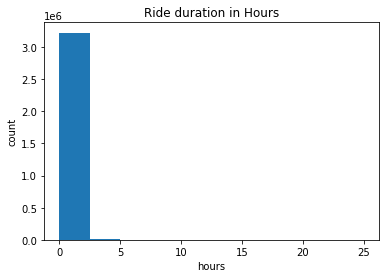

In [150]:
# Ride duration in Hours Plot
fig, ax = plt.subplots(1, 1)
duration_hr_max = df['duration_hr'].max()
ax.hist(df['duration_hr'], bins=10, range=(0,duration_hr_max+1.0))
ax.set_title('Ride duration in Hours')
ax.set_xlabel('hours')
ax.set_ylabel('count')
plt.show()

It is difficult to look at the histogram since most of the trips last between 0-2.5hrs. Let's look at a log plot:

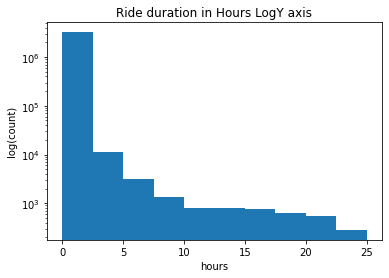

In [151]:
# Ride duration in Hours Log Plot
fig, ax = plt.subplots(1, 1)
duration_hr_max = df['duration_hr'].max()
ax.hist(df['duration_hr'], bins=10, range=(0,duration_hr_max+1.0))
ax.set_yscale('log')
ax.set_title('Ride duration in Hours LogY axis')
ax.set_xlabel('hours')
ax.set_ylabel('log(count)')
plt.show()

From the log plot histogram, we can see that the most common trips last less than 5hrs. There are some that last longer than 24hrs!!
Now I'll look into the trips that are less than 1hours, breaking it down by minute bins.

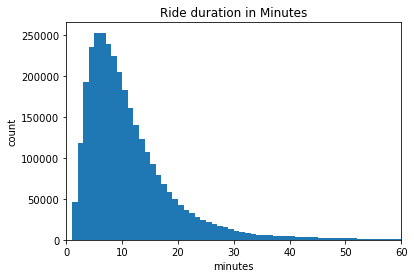

In [152]:
# Ride duration in Minutes Plot
fig, ax = plt.subplots(1, 1)
bins = np.arange(0, df['duration_min'].max() + 1.0, 1)
ax.hist(df['duration_min'], bins=bins)
ax.set_title('Ride duration in Minutes')
ax.set_xlabel('minutes')
ax.set_ylabel('count')
ax.set_xlim([0, 60])
plt.show()

The plot histogram above shows all trips <60mins in duration. The data shows that most trips last less than 20mins.

### User Exploration

First, I start by breaking down the bike users by subscription/customer type:

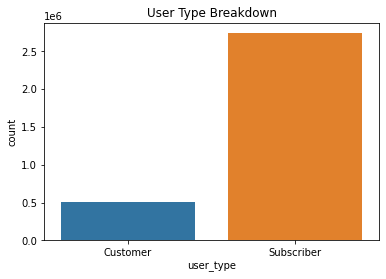

In [153]:
# User Type Breakdown
plt.figure()
plt.title('User Type Breakdown')
sb.countplot(data=df, x='user_type');

The plot above shows that the majority of users are subscribers. Subscribers means people that have a membership with the company for the bike ride share.
Now, let's look into the breakdown by gender.

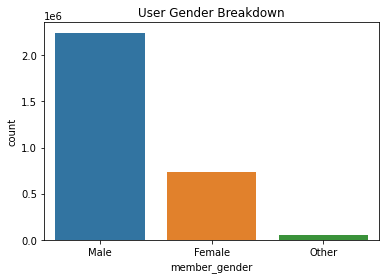

In [154]:
# User Gender Breakdown
plt.figure()
plt.title('User Gender Breakdown')
sb.countplot(data=df, x='member_gender');

The plot above shows that most of the users are males.
Let's look into the age of the riders.

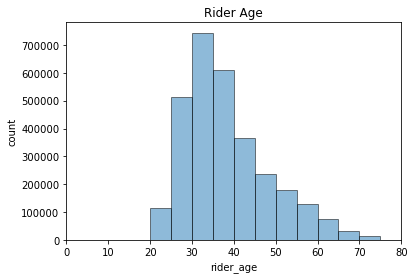

In [155]:
# age of riders
now = datetime.datetime.today()
df['rider_age'] = now.year - df['member_birth_year']
# create a histogram for rider age
fig, ax = plt.subplots(1, 1)
bins = np.arange(0, 80, 5)
ax.set_xlim(0,80)
ax.hist(df['rider_age'], bins=bins, alpha=0.5, histtype='bar', ec='black')
ax.set_xlabel('rider_age')
ax.set_ylabel('count')
ax.set_title('Rider Age')
plt.show()

Age range 30-35 years old is the most common for the riders. Very few riders less than 18years old since it is the requirement to rent one of the bikes. The oldest riders are on the 70-75 age range.

### Date of Ride Exploration

First, I'll look at the # of rides per month of the year

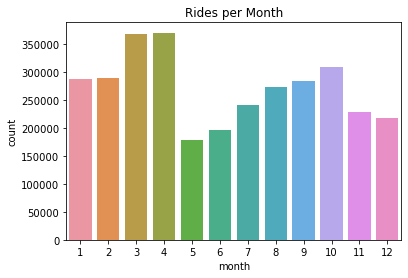

In [156]:
# Rides per Month plot
plt.figure()
plt.title('Rides per Month')
sb.countplot(data=df, x='month');

The most common months for bike use are March and April. The lowest month is May.

Now, I'll break it down by day of the week.

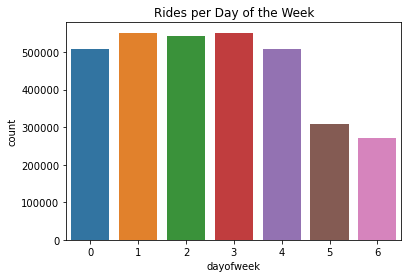

In [157]:
# Rides per Day of the Week Plot
plt.figure()
plt.title('Rides per Day of the Week')
sb.countplot(data=df, x='dayofweek');

Weekdays are the most common days for bike rides, weekends are the lowest.

## Station Exploration

In [158]:
print('top10 stations START')
# value counts for START stations
df_value_counts = pd.DataFrame(df['start_station_id'].value_counts())
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['start_station_id', 'counts']

top10 stations START


In [159]:
# create station DF
df_stations = df[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']]
df_stations.drop_duplicates(inplace=True)
df_stations.drop_duplicates(subset='start_station_id', inplace=True)

<ipython-input-159-03ee491a15e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations.drop_duplicates(inplace=True)
<ipython-input-159-03ee491a15e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations.drop_duplicates(subset='start_station_id', inplace=True)


In [160]:
# merge station and values DFs
df_stations = pd.merge(df_stations, df_value_counts, on='start_station_id', how='outer')
df_stations.sort_values('counts', axis=0, ascending=False, inplace=True)

In [161]:
# most common stations
df_stations.head(5)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,counts
100,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,67991
8,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,66643
31,58,Market St at 10th St,37.776619,-122.417385,64551
5,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,59937
60,81,Berry St at 4th St,37.775880,-122.393170,58722


The most popular station to start rides is the Ferry Building.

Now I'll look into the least common station to start a ride.

In [162]:
# most common stations
df_stations.tail(5)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,counts
364,417,Park Ave at Race St,37.326011,-121.912327,16
365,416,Auzerais Ave at Los Gatos Creek Trail,37.321182,-121.903090,10
369,418,17th St at Santa Clara St,37.343985,-121.874385,8
370,415,Delmas Ave at Virginia St,37.319757,-121.892999,5
371,420,SF Test Station,0.000000,0.000000,1


The least common station to start rides from is Bird Ave.

## Bike Utilization

In [163]:
# number of bikes
print()
print('the total number of bikes is:')
print(df['bike_id'].nunique())


the total number of bikes is:
6729


In [164]:
# total rides per bike
df_bikes_rides = df['bike_id'].value_counts().rename_axis('bike_id').reset_index(name='number_of_rides')
print()
print('total rides per bike is:')
print(df_bikes_rides['number_of_rides'].describe())


total rides per bike is:
count    6729.000000
mean      481.769059
std       346.165335
min         1.000000
25%       180.000000
50%       432.000000
75%       691.000000
max      1532.000000
Name: number_of_rides, dtype: float64


The mean # or rides per bike for the period 2017-2018 is:

In [165]:
df_bikes_rides['number_of_rides'].mean()

481.76905929558626

In [166]:
# total accumulated hours per bike
df_bikes_hr = df.groupby('bike_id')['duration_hr'].sum()
df_bikes_hr = df_bikes_hr.to_frame()
print()
print('total accumulated hours per bike is:')
print(df_bikes_hr['duration_hr'].describe())


total accumulated hours per bike is:
count    6729.000000
mean      116.675676
std        89.735713
min         0.038611
25%        40.915278
50%        98.715556
75%       172.025000
max       393.044444
Name: duration_hr, dtype: float64


The mean of accumulated hours per bike is:

In [167]:
df_bikes_hr['duration_hr'].mean()

116.6756763841416

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The ride duration had a very wide range, going from a few mins to 24hrs+. So I had to fine tune the histograms, in terms of log-Y plot as well as limiting the max duration and also consider hour and minute bins to fully appreciate the wide range of usage.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> The one that stood out the most was bike rides histograms based on months or day of the week. The data had to be transformed to month of the year and also day of the week. There was a big drop in the number of rides for the month of May. For the days of the week it was very noticeable that the weekends were not as busy compared to Monday-Friday.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

First, I'll start by investigating the user_type-duration_min connection:

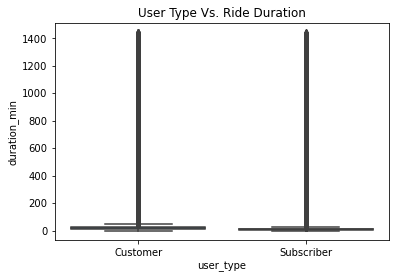

In [168]:
# Customer/Subscriber VS duration
plt.figure()
plt.title('User Type Vs. Ride Duration')
sb.boxplot(data=df, x='user_type', y='duration_min');

It is hard to read the boxplot, so I'll limit the Y-Axis next to mask some of the outliers:

(0.0, 55.0)

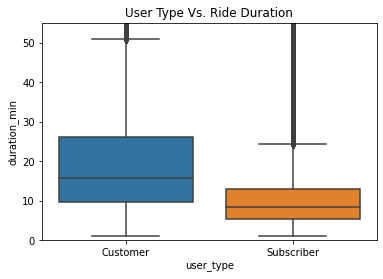

In [169]:
# Customer/Subscriber VS duration (no outliers)
plt.figure()
plt.title('User Type Vs. Ride Duration')
sb.boxplot(data=df, x='user_type', y='duration_min')
plt.ylim(0, 55)

It seems that Subscriber typically have shorter trips compared to Customers. This could be due to the fact that Subscribers use them to go to work or shop, whereas Customers may be people like tourist that use them for a longer time.

Now, I'll look into the dayofweek-duration_min connection:

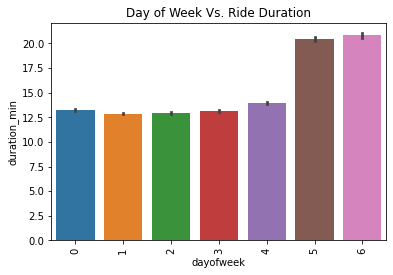

In [170]:
# WeekDay VS duration
plt.figure()
plt.title('Day of Week Vs. Ride Duration')
sb.barplot(data=df, x='dayofweek', y='duration_min')
plt.xticks(rotation=90)
plt.show()

Weekday trips are shorter compared to Weekend trips. This is an interesting find that can be compared to the fact that most of the rides occur Monday-Friday.

Now I'll break it down into dayofweek vs subscriber/customer type:

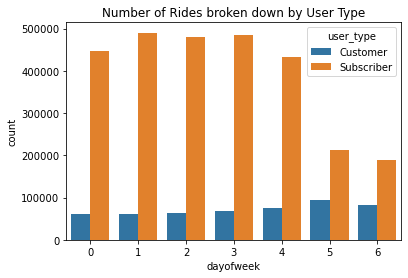

In [171]:
# Number of Rides broken down by User Type
fig, ax = plt.subplots()
plt.title('Number of Rides broken down by User Type')
sb.countplot(data=df, x='dayofweek', hue='user_type', ax=ax)
plt.show()

Subscribers take more trips during the week and Customers take more trips during the weekends.

Let's look at the duration_min-month connection:

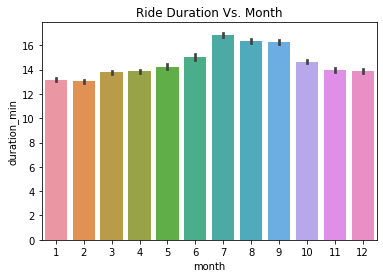

In [172]:
# Ride Duration Vs. Month
fig, ax = plt.subplots()
plt.title('Ride Duration Vs. Month')
sb.barplot(data=df, x='month', y='duration_min', ax=ax)
plt.show()

The trips are longer during the summer months. This makes sense since the Bay area has a very nice weather during the summer months. It will make people spend more time outdoors.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> The one that stood out was the ride duration per subscriber/customer type. It was very evident that customers(casual users) spend a lot more time during rides. This maybe because they may be tourist visiting the area.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> It was very interesting that subscribers use the bikes more frequently Monday-Friday, as opposed to customers that use them more Saturday-Sunday. There seem to be a tradeoff between the two types of users during the week. This is a nice balance for a business.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

Now, expanding on the dayweek-user_type connection. I'll look into the duration_min-dayofweek connection breaking it down by subscriber/customer type:

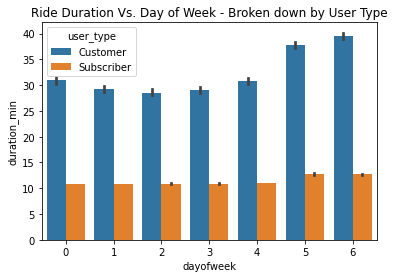

In [173]:
# Ride Duration Vs. Day of Week - Broken down by User Type
fig, ax = plt.subplots()
plt.title('Ride Duration Vs. Day of Week - Broken down by User Type')
sb.barplot(x='dayofweek', y='duration_min', hue='user_type', data=df, ax=ax)
plt.show()

If the trip duration by dayofweek is broken into Subscriber/Customer, it can be seen that for both groups, trips are longer during weekends.

Let's look into the day of the month ride duration per month:

<Figure size 432x288 with 0 Axes>

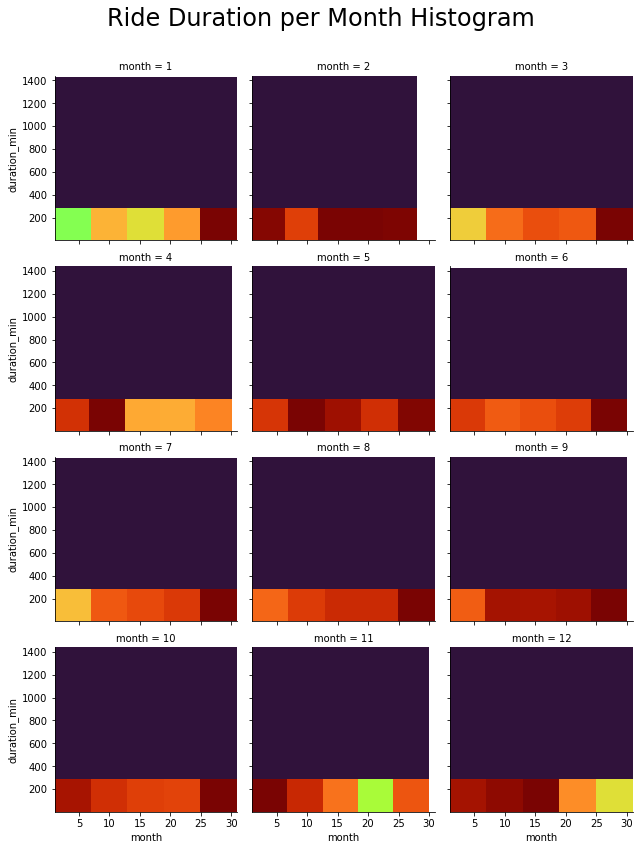

In [174]:
# create a function to from Matplotlib hist2d
def h2dgrid(x, y, **kwargs):
    palette = kwargs.pop('color')
    plt.hist2d(x, y, cmap = palette, cmin = 0.5, bins=5)
    
# faceted heatmap histogram: months and duration
plt.figure()
g = sb.FacetGrid(data=df, col='month', col_wrap=3, height=3)
g.map(h2dgrid, 'day', 'duration_min', color = 'turbo')
g.fig.suptitle('Ride Duration per Month Histogram', fontsize=24)
g.fig.subplots_adjust(top=0.9)
g.set_xlabels('month')
g.set_ylabels('duration_min')
#g.set(ylim=(0, 60))
plt.show()

Using the above 2D histograms broken down per month does not seem to be very good at pointing at any conclusions in the data.

Let's try Seaborn's point plot feature:

<Figure size 432x288 with 0 Axes>

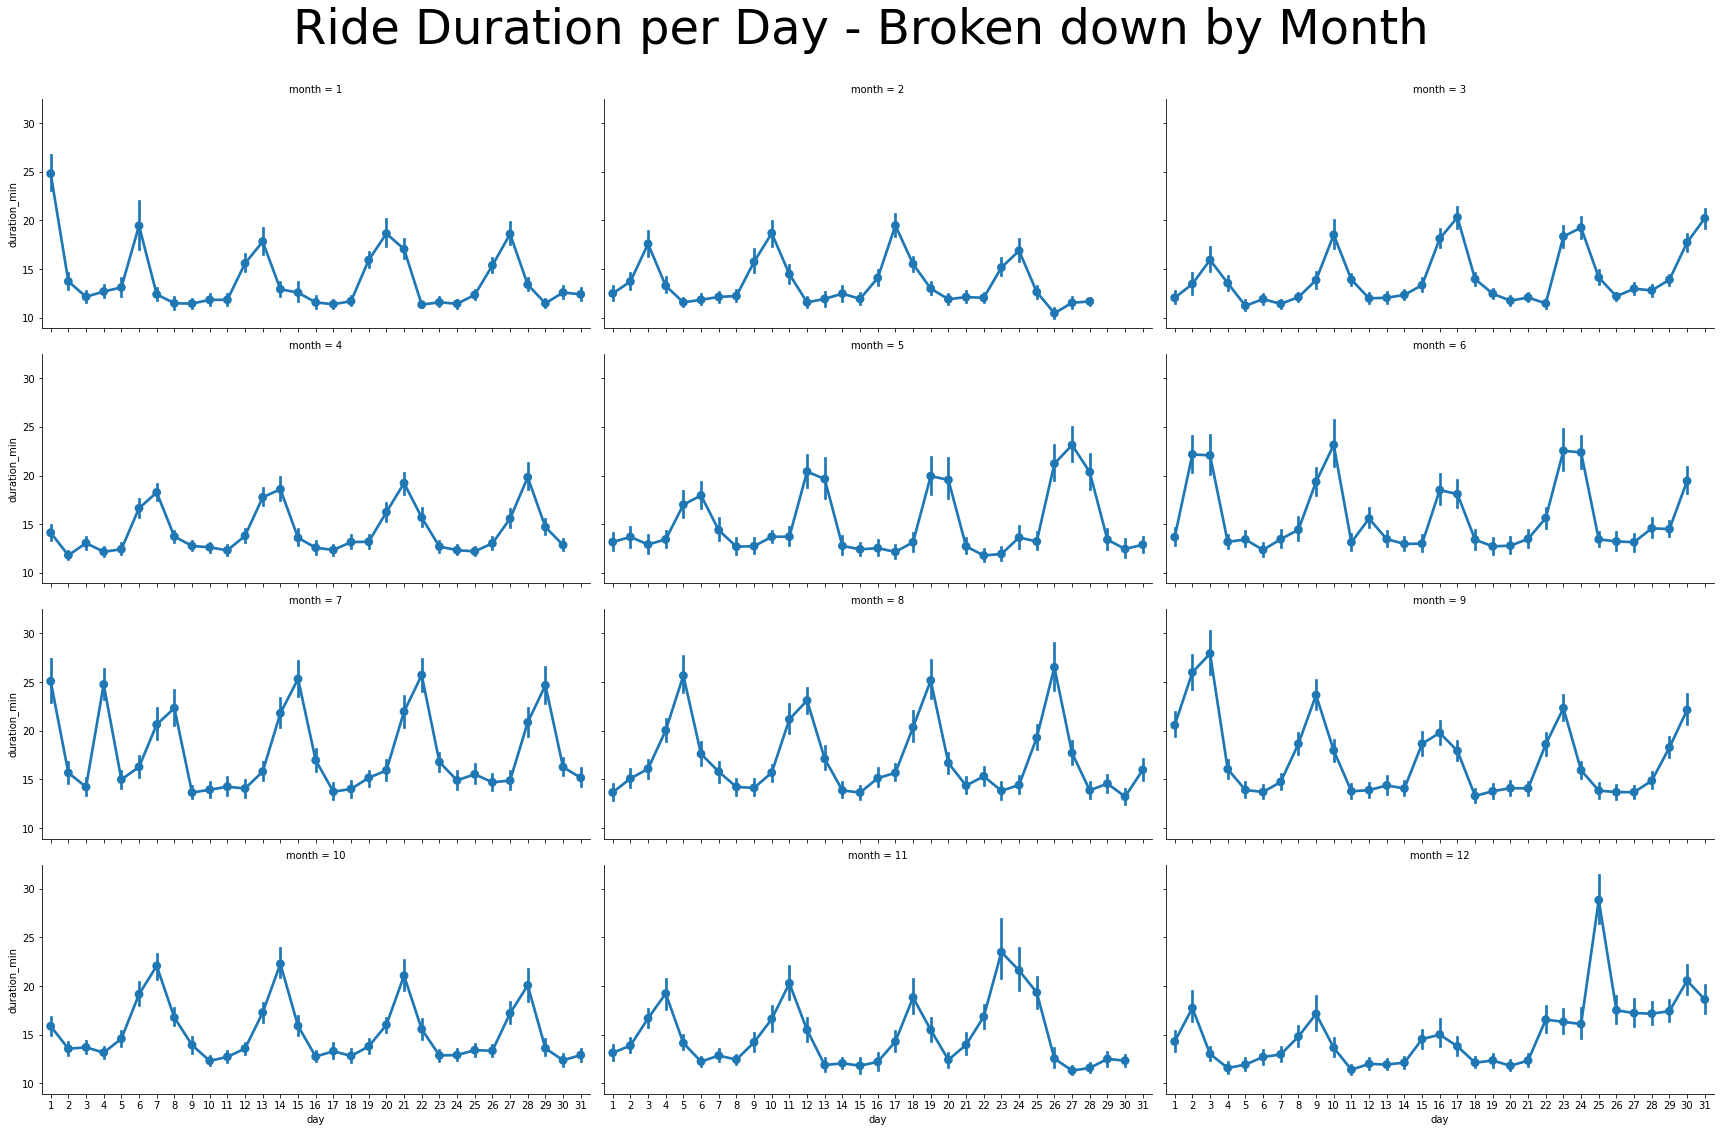

In [175]:
# Ride Duration per Day - Broken down by Month
plt.figure()
g = sb.FacetGrid(data=df, col='month', col_wrap=3, height=4, aspect=2.0)
g.map(sb.pointplot,'day', 'duration_min', order=None)
g.fig.suptitle('Ride Duration per Day - Broken down by Month', fontsize=48)
g.fig.subplots_adjust(top=0.9)
plt.show()

The plots above show that almost for every moth, the bike_duration spikes every 7 days. This is similar to what we saw before for bike_duration during weekends on the Bivariate analysis. Also, the day of the month is not very meaningful since it changes month by month.

Instead of using the day # of the month (ex. 0 thru 31), let's use day of week:

<Figure size 432x288 with 0 Axes>

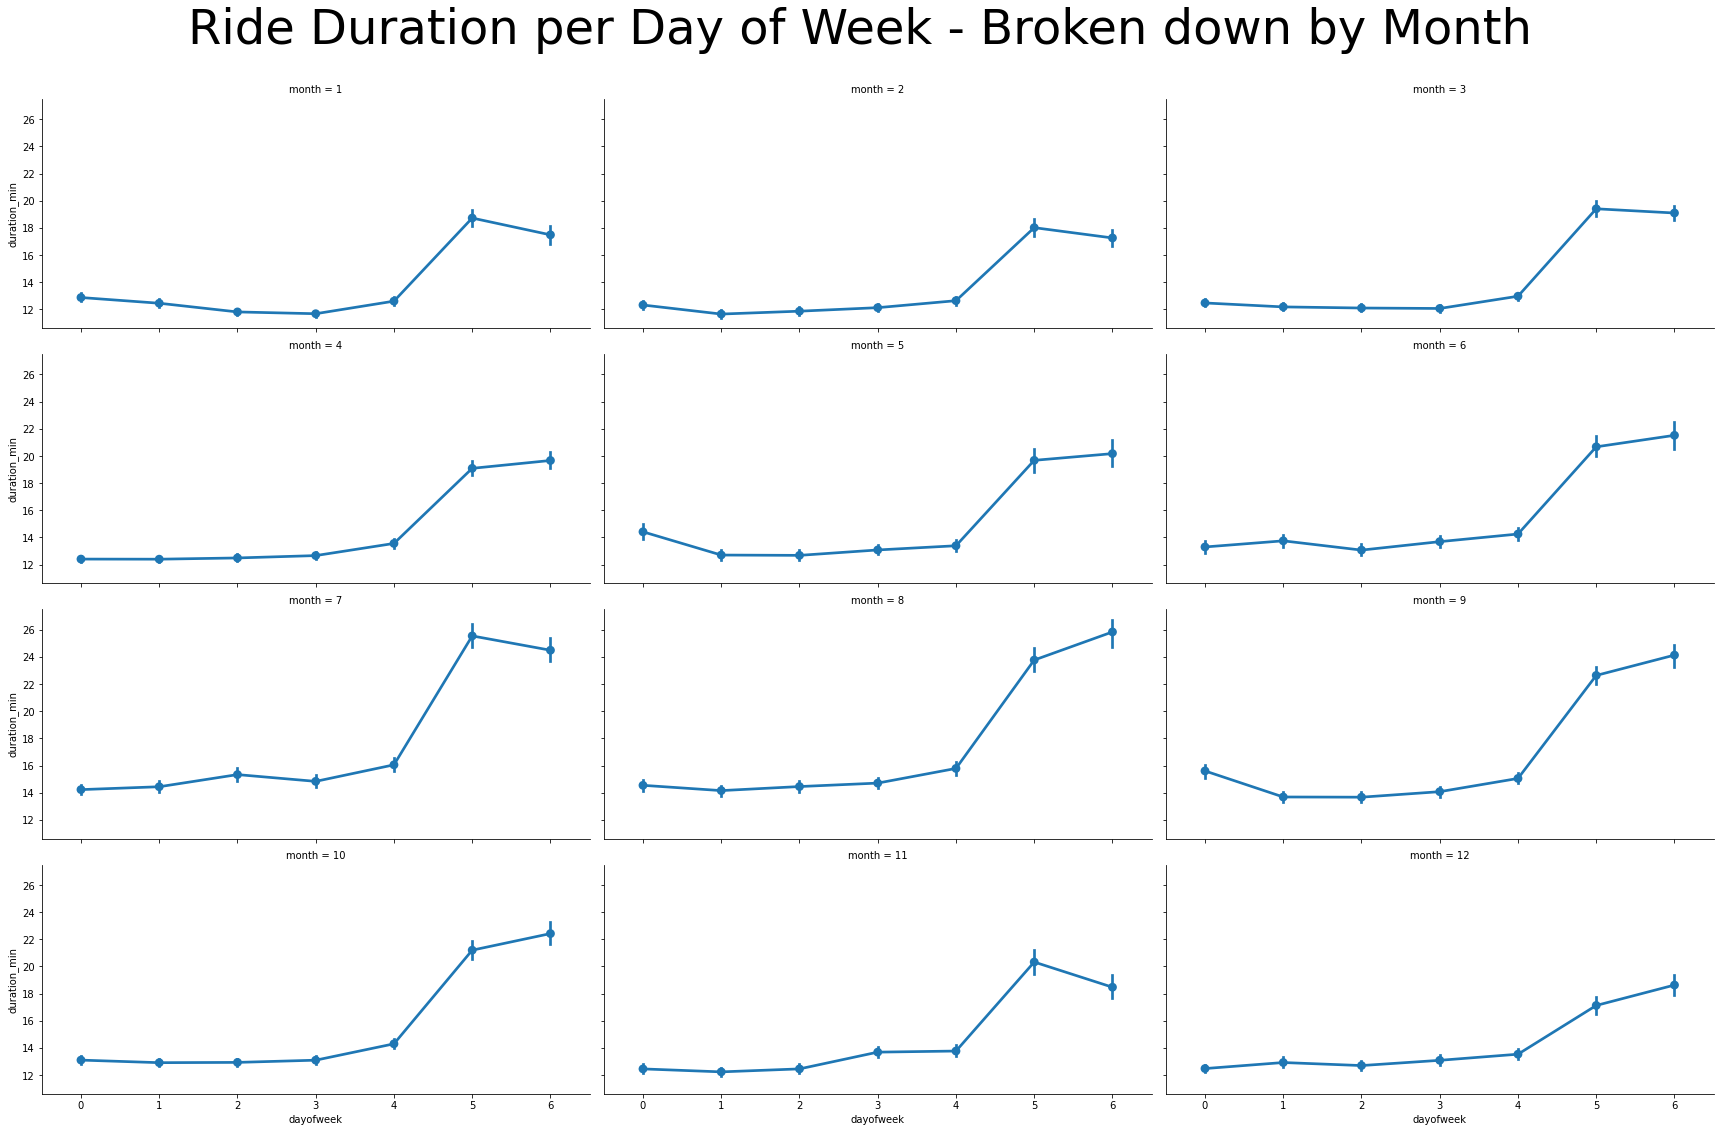

In [176]:
# Ride Duration per Day of Week - Broken down by Month
plt.figure()
g = sb.FacetGrid(data=df, col='month', col_wrap=3, height=4, aspect=2.0)
g.map(sb.pointplot,'dayofweek', 'duration_min', order=None)
g.fig.suptitle('Ride Duration per Day of Week - Broken down by Month', fontsize=48)
g.fig.subplots_adjust(top=0.9)
plt.show()

It is a lot clearer now that the bike duration_min is definitely higher for all months on Saturday-Sunday.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The bike ride duration_min definitely stands out as being higher overall during the weekends.

### Were there any interesting or surprising interactions between features?

> Subscribers duration_min during Monday-Friday is pretty constant. This may be due to the fact that they use it for transportation and/or shopping. So the numbers are very consistent.

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

### Save DFs for Explanatory Jupyter Notebook

In [177]:
# save all dataframes to pickle (to be used in Explanatory Notebook part
df.to_pickle('df.pkl')
df_bikes_rides.to_pickle('df_bikes_rides.pkl')
df_bikes_hr.to_pickle('df_bikes_hr.pkl')
df_stations.to_pickle('df_stations.pkl')